# Intro
This notebook represents manipulations with eSRGAN model from: https://github.com/xinntao/ESRGAN

**1. Test launch**
> In this part I clone the mmsr repo, where currently up-to-date models on image super-resolution are available. Here I use pretrained eSRGAN to launch on image from article and visualize it. I use pretrained model with best perceptive results, not PSNR

**2. Training**
> In this part I use training dataset, generated from images of Z1 fluorescent microscopy. Initial 2D slices were divided into parts with random size from 64 to 256 pixels, downscaled and saved as pairs. I use `train.py` file to provide with training, also I set pretrained perceived-best eSRGAN model and set 500 iterations for discriminator to solely work (to make sure that discriminator adapted to new data distribution.

**3. Validate**
> In this part I visualize the results of both models: perceived-eSRGAN and fine-tuned eSRGAN on validation set.

In [1]:
import sys
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch

# Necessary for training logging
#!pip install --upgrade tensorboard

# Necessary for training dataset preparation
#!pip install lmdb

<hr>

# 1. Test launch

### Cloning and example of starting models

In [2]:
#!git clone https://github.com/open-mmlab/mmsr

# OLD variant, that was previously known before SRGAN, eSRGAN, SRRESNET and new EDVR concantenated into opem-mmsr project
#!git clone https://github.com/xinntao/ESRGAN 

download model weights from https://drive.google.com/drive/u/0/folders/17VYV_SoZZesU6mbxz2dMAIccSSlqLecY

Put model weights to `/ESRGAN/models/` or into `/mmsr/experiments/pretrained_models/`

### Launch pretrained ESRGAN model

In [8]:
sys.path.insert(0, '/home/roman_kiryanov/mmsr/codes/')
import RRDBNet_arch as arch

In [16]:
device = torch.device(0) #'cpu'

models_path = './mmsr/experiments/pretrained_models/'
esrgan_model_name = 'RRDB_ESRGAN_x4.pth' 
#esrgan_model_name = 'RRDB_PSNR_x4.pth' 
esrgan_model_path = os.path.join(models_path, esrgan_model_name)

esrgan = arch.RRDBNet(3, 3, 64, 23, gc=32)
esrgan.load_state_dict(torch.load(esrgan_model_path), strict=True)
esrgan.eval()
esrgan = esrgan.to(device)

(90, 62, 3)
torch.Size([1, 3, 90, 62])


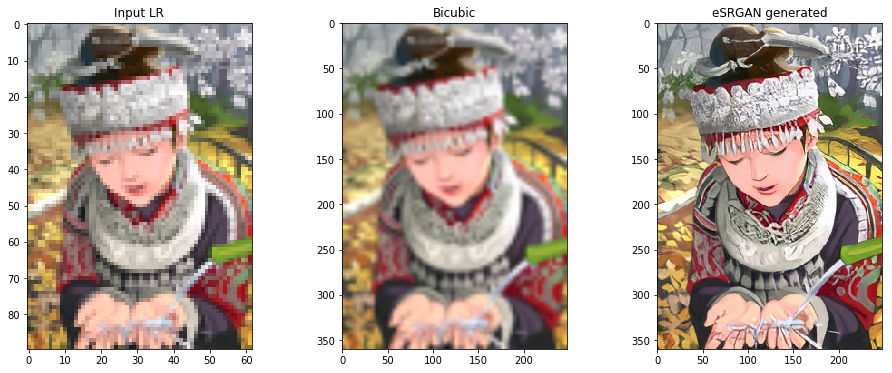

In [14]:
img_path = './ESRGAN/LR'
img_name = 'comic.png'

# Read bicubic downsampled image
img_lr = cv2.cvtColor( cv2.imread(os.path.join(img_path, img_name), -1), cv2.COLOR_BGR2RGB)
print(img_lr.shape)

# Increase the size - bicubic 'reference'
img_bicubic = cv2.resize(img_lr, (int(img_lr.shape[1]*4), int(img_lr.shape[0]*4)), cv2.INTER_CUBIC)

# Convert image to model suitable input size
img_lr_to_model = torch.from_numpy(np.transpose(img_lr[:, :, [2, 1, 0]], (2, 0, 1))).float()
img_lr_to_model = img_lr_to_model/255
img_lr_to_model = img_lr_to_model.unsqueeze(0)
img_lr_to_model = img_lr_to_model.to(device)
print(img_lr_to_model.shape)

# Generate eSRGAN image
img_generated = esrgan(img_lr_to_model).data.squeeze().float().cpu().clamp_(0, 1).numpy()
img_generated = np.transpose(img_generated[[2, 1, 0], :, :], (1, 2, 0))
img_generated = np.clip(img_generated*255, 0,255)
img_generated = img_generated.astype(np.uint8)

plt.figure(figsize=(16,6))
plt.subplot(131)
plt.imshow(img_lr)
plt.title('Input LR')
plt.subplot(132)
plt.imshow(img_bicubic)
plt.title('Bicubic')
plt.subplot(133)
plt.imshow(img_generated)
plt.title('eSRGAN generated')
plt.show()

<hr>

# 2. Fine Tuning

In [2]:
cur_dir = os.getcwd()
if 'mmsr/codes/' in cur_dir:
    pass
else:
    print(cur_dir)

/home/roman_kiryanov


In [3]:
os.chdir('mmsr/codes/')
os.getcwd()

'/home/roman_kiryanov/mmsr/codes'

In [39]:
train_fol_gt = '../datasets/train_data_Z1_GT_additional180120/'
train_fol_lr = '../datasets/train_data_Z1_LR_additional180120/'
len(os.listdir(train_fol_gt)), len(os.listdir(train_fol_lr))

(3000, 3000)

In [40]:
os.listdir(train_fol_gt)[:3], os.listdir(train_fol_lr)[:3]

(['train_Z1_000981.png', 'train_Z1_002957.png', 'train_Z1_001723.png'],
 ['train_Z1_000981.png', 'train_Z1_002957.png', 'train_Z1_001723.png'])

In [42]:
!python train.py  -opt options/train/train_ESRGAN.yml

export CUDA_VISIBLE_DEVICES=0,1,2
Disabled distributed training.
Path already exists. Rename it to [/home/roman_kiryanov/mmsr/experiments/1801_RRDB_ESRGANx4_Z1_archived_200118-133353]
20-01-18 13:33:53.859 - INFO:   name: 1801_RRDB_ESRGANx4_Z1
  use_tb_logger: True
  model: srgan
  distortion: sr
  scale: 4
  gpu_ids: [0, 1, 2]
  datasets:[
    train:[
      name: z1_train
      mode: LQGT
      dataroot_GT: ../datasets/train_data_Z1_GT_additional180120
      dataroot_LQ: ../datasets/train_data_Z1_LR_additional180120
      use_shuffle: True
      n_workers: 6
      batch_size: 8
      GT_size: 128
      use_flip: True
      use_rot: True
      color: RGB
      phase: train
      scale: 4
      data_type: img
    ]
    val:[
      name: z1_val
      mode: LQGT
      dataroot_GT: ../datasets/val_data_Z1_GT
      dataroot_LQ: ../datasets/val_data_Z1_LR
      phase: val
      scale: 4
      data_type: img
    ]
  ]
  network_G:[
    which_model_G: RRDBNet
    in_nc: 3
    out_nc: 3
    nf:

<hr>

# 3. Validate
The visual part - validation

In [2]:
os.getcwd()

'/home/roman_kiryanov'

In [3]:
sys.path.insert(0, '/home/roman_kiryanov/mmsr/codes/')
sys.path.insert(0, '/home/roman_kiryanov/mmsr/codes/models/archs/')
import RRDBNet_arch as arch

In [6]:
device = 'cpu' #torch.device(0) 

esrgan = arch.RRDBNet(3, 3, 64, 23, gc=32)
esrgan.load_state_dict(torch.load('./mmsr/experiments/pretrained_models/RRDB_ESRGAN_x4.pth'), strict=True)
esrgan.eval()
esrgan = esrgan.to(device)

In [7]:
# 16.01.2020
fine_tune_esrgan = arch.RRDBNet(3, 3, 64, 23, gc=32)
fine_tune_esrgan.load_state_dict(torch.load('./mmsr/experiments/1401_RRDB_ESRGANx4_Z1/models/latest_G.pth'), strict=True)
fine_tune_esrgan.eval()
fine_tune_esrgan = fine_tune_esrgan.to(device)

In [8]:
# 18.01.2020
fine_tune_esrgan_2 = arch.RRDBNet(3, 3, 64, 23, gc=32)
fine_tune_esrgan_2.load_state_dict(torch.load('./mmsr/experiments/1801_RRDB_ESRGANx4_Z1/models/10000_G.pth'), strict=True)
fine_tune_esrgan_2.eval()
fine_tune_esrgan_2 = fine_tune_esrgan_2.to(device)

In [32]:
test_folder_lr = './mmsr/datasets/val_data_Z1_LR/' 
test_folder_gt = './mmsr/datasets/val_data_Z1_GT/' 

images = os.listdir(test_folder_gt)
images = [i for i in images if i.endswith('.png')]
img_name = np.random.choice(images)

print(img_name)

valid_Z1_000169.png


In [13]:
from skimage.measure import compare_psnr, compare_ssim
import pandas as pd

(32, 32, 3)
(128, 128, 3)
(128, 128, 3)
torch.Size([1, 3, 32, 32])


/home/roman_kiryanov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  del sys.path[0]
/home/roman_kiryanov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  
/home/roman_kiryanov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/home/roman_kiryanov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed f

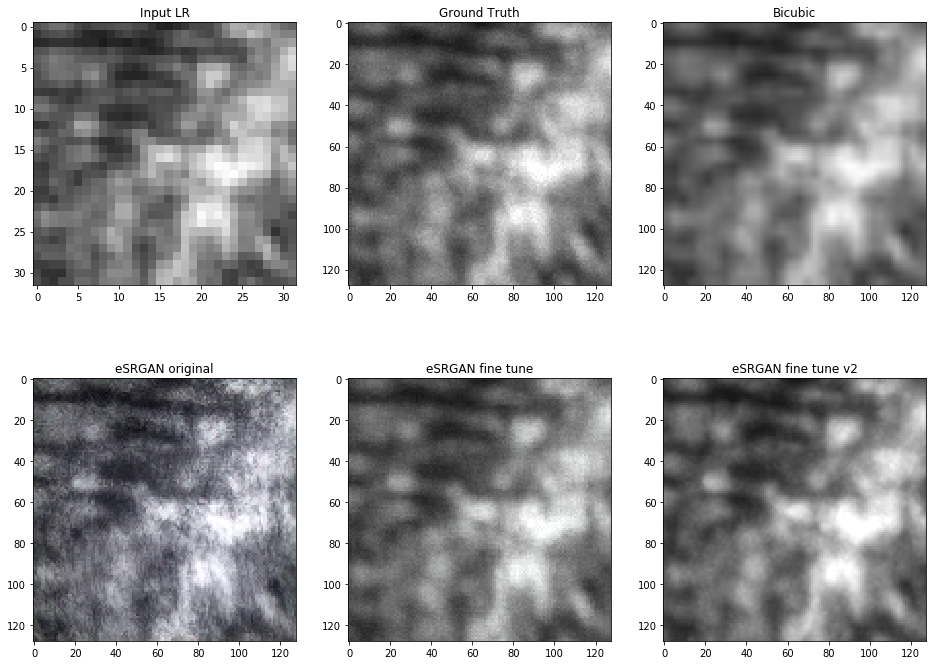

In [33]:
metrics = pd.DataFrame(index=['psnr','ssim'], columns=['bicubic','eSRGAN','fine-tune eSRGAN'])

# Read bicubic downsampled image
img_lr = cv2.cvtColor( cv2.imread(os.path.join(test_folder_lr, img_name), -1), cv2.COLOR_BGR2RGB)
print(img_lr.shape)
img_gt = cv2.cvtColor( cv2.imread(os.path.join(test_folder_gt, img_name), -1), cv2.COLOR_BGR2RGB)
print(img_gt.shape)

# Increase the size - bicubic 'reference'
img_bicubic = cv2.resize(img_lr, (int(img_lr.shape[1]*4), int(img_lr.shape[0]*4)), cv2.INTER_CUBIC)
print(img_bicubic.shape)

p = compare_psnr(img_gt[:,:,0], img_bicubic[:,:,0])
s = compare_ssim(img_gt[:,:,0], img_bicubic[:,:,0])
metrics.loc['psnr','bicubic'] = p
metrics.loc['ssim','bicubic'] = s

# Convert image to model suitable input size
img_lr_to_model = torch.from_numpy(np.transpose(img_lr[:, :, [2, 1, 0]], (2, 0, 1))).float()
img_lr_to_model = img_lr_to_model/255
img_lr_to_model = img_lr_to_model.unsqueeze(0)
img_lr_to_model = img_lr_to_model.to(device)
print(img_lr_to_model.shape)

# Original Esrgan
with torch.no_grad():
    img_generated_o = esrgan(img_lr_to_model)
img_generated_o = img_generated_o.data.squeeze().float().cpu().clamp_(0, 1).numpy()
img_generated_o = np.transpose(img_generated_o[[2, 1, 0], :, :], (1, 2, 0))
img_generated_o = np.clip(img_generated_o*255, 0,255)
img_generated_o = img_generated_o.astype(np.uint8)

p = compare_psnr(img_gt[:,:,0], img_generated_o[:,:,0])
s = compare_ssim(img_gt[:,:,0], img_generated_o[:,:,0])
metrics.loc['psnr','eSRGAN'] = p
metrics.loc['ssim','eSRGAN'] = s


# fine tune Esrgan
with torch.no_grad():
    img_generated_f = fine_tune_esrgan(img_lr_to_model)
img_generated_f = img_generated_f.data.squeeze().float().cpu().clamp_(0, 1).numpy()
img_generated_f = np.transpose(img_generated_f[[2, 1, 0], :, :], (1, 2, 0))
img_generated_f = np.clip(img_generated_f*255, 0,255)
img_generated_f = img_generated_f.astype(np.uint8)


# fine tune Esrgan
with torch.no_grad():
    img_generated_f_2 = fine_tune_esrgan_2(img_lr_to_model)
img_generated_f_2 = img_generated_f_2.data.squeeze().float().cpu().clamp_(0, 1).numpy()
img_generated_f_2 = np.transpose(img_generated_f_2[[2, 1, 0], :, :], (1, 2, 0))
img_generated_f_2 = np.clip(img_generated_f_2*255, 0,255)
img_generated_f_2 = img_generated_f_2.astype(np.uint8)


p = compare_psnr(img_gt[:,:,0], img_generated_f_2[:,:,0])
s = compare_ssim(img_gt[:,:,0], img_generated_f_2[:,:,0])
metrics.loc['psnr','fine-tune eSRGAN'] = p
metrics.loc['ssim','fine-tune eSRGAN'] = s

torch.cuda.empty_cache()

# Plot images
plt.figure(figsize=(16,12))
plt.subplot(231)
plt.imshow(img_lr)
plt.title('Input LR')

plt.subplot(232)
plt.imshow(img_gt)
plt.title('Ground Truth')

plt.subplot(233)
plt.imshow(img_bicubic)
plt.title('Bicubic')

plt.subplot(234)
plt.imshow(img_generated_o)
plt.title('eSRGAN original')

plt.subplot(235)
plt.imshow(img_generated_f)
plt.title('eSRGAN fine tune')

plt.subplot(236)
plt.imshow(img_generated_f_2)
plt.title('eSRGAN fine tune v2')
plt.show()

In [34]:
display(metrics)

,bicubic,eSRGAN,fine-tune eSRGAN
psnr,31.0851,24.3182,29.1241
ssim,0.871876,0.642288,0.855891


(90, 62, 3)
(360, 248, 3)
torch.Size([1, 3, 90, 62])


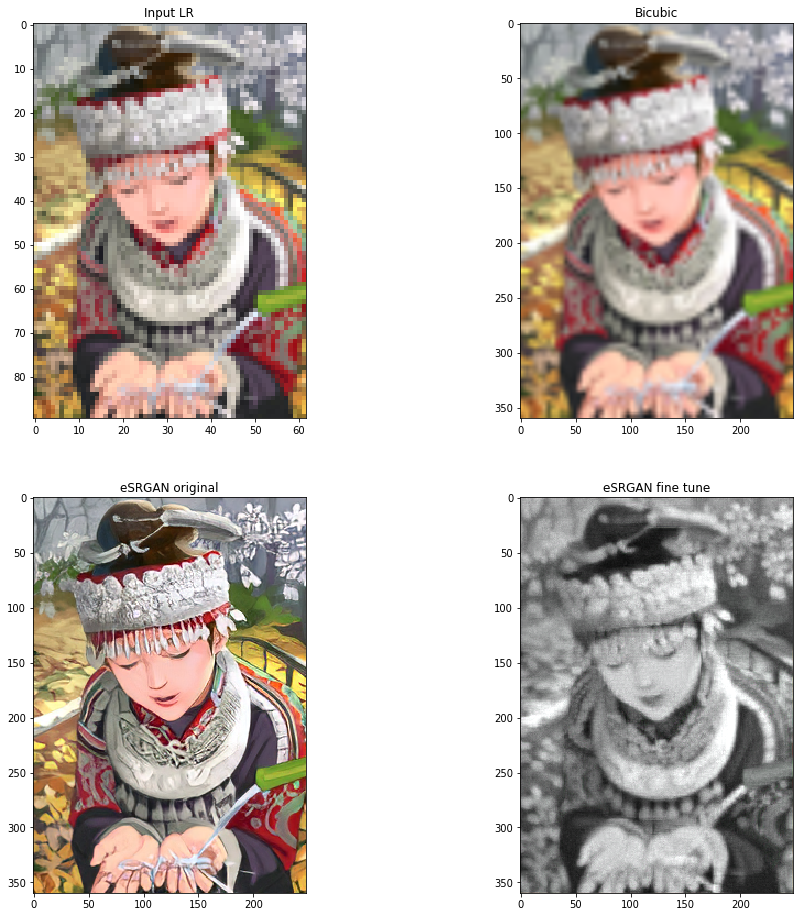

In [41]:
# Read bicubic downsampled image
folder = './ESRGAN/LR/'
img_name = 'comic.png'

img_lr = cv2.cvtColor( cv2.imread(os.path.join(folder, img_name), -1), cv2.COLOR_BGR2RGB)
print(img_lr.shape)

# Increase the size - bicubic 'reference'
img_bicubic = cv2.resize(img_lr, (int(img_lr.shape[1]*4), int(img_lr.shape[0]*4)), cv2.INTER_CUBIC)
print(img_bicubic.shape)

# Convert image to model suitable input size
img_lr_to_model = torch.from_numpy(np.transpose(img_lr[:, :, [2, 1, 0]], (2, 0, 1))).float()
img_lr_to_model = img_lr_to_model/255
img_lr_to_model = img_lr_to_model.unsqueeze(0)
img_lr_to_model = img_lr_to_model.to(device)
print(img_lr_to_model.shape)


# Original Esrgan
img_generated_o = esrgan(img_lr_to_model).data.squeeze().float().cpu().clamp_(0, 1).numpy()
img_generated_o = np.transpose(img_generated_o[[2, 1, 0], :, :], (1, 2, 0))
img_generated_o = np.clip(img_generated_o*255, 0,255)
img_generated_o = img_generated_o.astype(np.uint8)


# fine tune Esrgan
img_generated_f = fine_tune_esrgan(img_lr_to_model).data.squeeze().float().cpu().clamp_(0, 1).numpy()
img_generated_f = np.transpose(img_generated_f[[2, 1, 0], :, :], (1, 2, 0))
img_generated_f = np.clip(img_generated_f*255, 0,255)
img_generated_f = img_generated_f.astype(np.uint8)


# Plot images
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.imshow(img_lr)
plt.title('Input LR')

plt.subplot(222)
plt.imshow(img_bicubic)
plt.title('Bicubic')

plt.subplot(223)
plt.imshow(img_generated_o)
plt.title('eSRGAN original')

plt.subplot(224)
plt.imshow(img_generated_f)
plt.title('eSRGAN fine tune')
plt.show()

<hr>

# La fin